## Flipkart Reviews Sentiment Analysis

In [1]:
#All necessary imports
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df=pd.read_csv('datasets/Dataset-SA.csv')

In [3]:
df.head()

,product_name,product_price,Rate,Review,Summary,Sentiment
0,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,super!,great cooler excellent air flow and for this p...,positive
1,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,5,awesome,best budget 2 fit cooler nice cooling,positive
2,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,the quality is good but the power of air is de...,positive
3,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,1,useless product,very bad product its a only a fan,negative
4,Candes 12 L Room/Personal Air Cooler??????(Whi...,3999,3,fair,ok ok product,neutral


In [4]:
df.shape

(205052, 6)

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 205052 entries, 0 to 205051
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   product_name   205052 non-null  str  
 1   product_price  205052 non-null  str  
 2   Rate           205052 non-null  str  
 3   Review         180388 non-null  str  
 4   Summary        205041 non-null  str  
 5   Sentiment      205052 non-null  str  
dtypes: str(6)
memory usage: 9.4 MB


Dropping unwanted cols

In [6]:
df.drop(columns=['product_name','product_price'],inplace=True)

In [7]:
df.head(5)

,Rate,Review,Summary,Sentiment
0,5,super!,great cooler excellent air flow and for this p...,positive
1,5,awesome,best budget 2 fit cooler nice cooling,positive
2,3,fair,the quality is good but the power of air is de...,positive
3,1,useless product,very bad product its a only a fan,negative
4,3,fair,ok ok product,neutral


In [8]:
df.rename(columns={'Rate':'Rating'},inplace=True)

In [9]:
df['Rating'].value_counts()

Rating
5                                                                    118765
4                                                                     41894
1                                                                     21300
3                                                                     16599
2                                                                      6491
Pigeon Favourite Electric Kettle??????(1.5 L, Silver, Black)              1
Bajaj DX 2 L/W Dry Iron                                                   1
Nova Plus Amaze NI 10 1100 W Dry Iron?ÃÂ¿?ÃÂ¿(Grey & Turquoise)         1
Name: count, dtype: int64

In [10]:
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df = df.dropna(subset=['Rating'])
df = df[df['Rating'].isin([1, 2, 3, 4, 5])]


In [11]:
df['Rating'].isnull().sum()

np.int64(0)

In [12]:
df['Rating'].value_counts()


Rating
5.0    118765
4.0     41894
1.0     21300
3.0     16599
2.0      6491
Name: count, dtype: int64

In [13]:
df.shape

(205049, 4)

In [14]:
df.info()

<class 'pandas.DataFrame'>
Index: 205049 entries, 0 to 205051
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Rating     205049 non-null  float64
 1   Review     180385 non-null  str    
 2   Summary    205038 non-null  str    
 3   Sentiment  205049 non-null  str    
dtypes: float64(1), str(3)
memory usage: 7.8 MB


In [15]:
df['Review'].value_counts()

Review
wonderful                                                  9016
not specified                                              8351
brilliant                                                  5643
awesome                                                    5636
great product                                              5622
                                                           ... 
super! good product                                           1
awesome daily use crockery                                    1
good quality dinner set                                       1
good quality product and good option for some one gift.       1
product looking very nice & strong quality                    1
Name: count, Length: 1321, dtype: int64

**To improve model generalization, we removed empty and extremely short reviews, and limited duplicate reviews while retaining sufficient short-text sentiment signals.**

Combine Review + Summary into ONE text column

In [16]:
import re
import emoji

def clean_text(text):
    if text is None:
        return ""
    
    text = str(text)

    # remove HTML
    text = re.sub(r"<.*?>", "", text)

    # lowercase
    text = text.lower()

    # remove URLs
    text = re.sub(r"http\S+|www.\S+", "", text)

    # remove emojis
    text = emoji.replace_emoji(text, replace="")

    # remove special chars except .,!?'
    text = re.sub(r"[^a-zA-Z0-9\s.,!?']", " ", text)

    # normalize repeated characters
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)

    # remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


def preprocess_row(summary, review):
    """Combine summary + review into a single cleaned input."""
    summary = clean_text(summary)
    review = clean_text(review)
    return (summary + " " + review).strip()

In [17]:
df["final_text"] = df.apply(
    lambda row: preprocess_row(row["Summary"], row["Review"]),
    axis=1
)

df["label"] = df["Sentiment"].map({"positive": 1, "negative": 0})
df = df.dropna(subset=["final_text", "label"])

In [18]:
# df['Review'] = df['Review'].fillna('')
# df['Summary'] = df['Summary'].fillna('')

# df['Comment'] = df['Summary'] + '. ' + df['Review']


In [19]:
df.drop(columns=['Review','Summary' ,'Rating'],inplace=True)

In [20]:
df.head()

,Sentiment,final_text,label
0,positive,great cooler excellent air flow and for this p...,1.0
1,positive,best budget 2 fit cooler nice cooling awesome,1.0
2,positive,the quality is good but the power of air is de...,1.0
3,negative,very bad product its a only a fan useless product,0.0
5,positive,the cooler is really fantastic and provides go...,1.0


In [21]:
df['label'].value_counts()

label
1.0    166579
0.0     28231
Name: count, dtype: int64

Encoding My sentiment

In [22]:
# df['Sentiment']= df['Sentiment'].map({'positive':1,'negative':0,'neutral':2})

In [23]:
df.head()

,Sentiment,final_text,label
0,positive,great cooler excellent air flow and for this p...,1.0
1,positive,best budget 2 fit cooler nice cooling awesome,1.0
2,positive,the quality is good but the power of air is de...,1.0
3,negative,very bad product its a only a fan useless product,0.0
5,positive,the cooler is really fantastic and provides go...,1.0


In [24]:
df.drop(columns=['Sentiment'] , inplace=True)

In [25]:
# df.drop(columns=['Rating'], inplace=True)

In [26]:
df.head()

,final_text,label
0,great cooler excellent air flow and for this p...,1.0
1,best budget 2 fit cooler nice cooling awesome,1.0
2,the quality is good but the power of air is de...,1.0
3,very bad product its a only a fan useless product,0.0
5,the cooler is really fantastic and provides go...,1.0


In [27]:
# sentiment_map = {0: "Negative", 1: "Positive", 2: "Neutral"}
# df["Sentiment_Label"] = df["Sentiment"].map(sentiment_map)


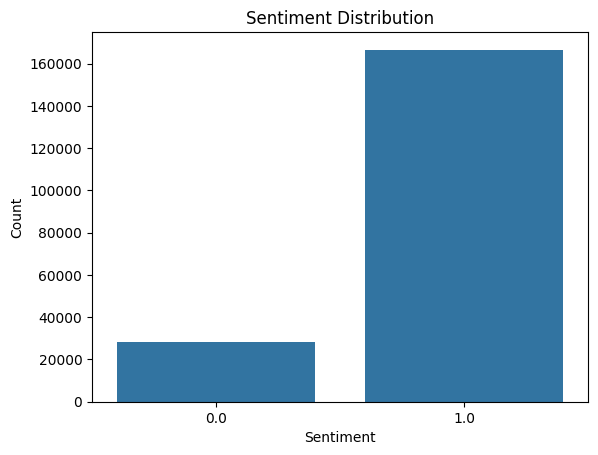

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.countplot(x="label", data=df)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [29]:
X = df["final_text"]
y = df["label"]


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [31]:
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2)
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [32]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC()
}


In [33]:
for name, model in models.items():
    print(f"\n🔹 Model: {name}")

    # Train
    model.fit(X_train_vec, y_train)

    # Predict
    y_pred = model.predict(X_test_vec)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)

    # Full classification report
    print(classification_report(y_test, y_pred))



🔹 Model: Logistic Regression
Accuracy: 0.9648375340074945
              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87      8428
         1.0       0.97      0.99      0.98     50015

    accuracy                           0.96     58443
   macro avg       0.95      0.91      0.93     58443
weighted avg       0.96      0.96      0.96     58443


🔹 Model: Naive Bayes
Accuracy: 0.9414643327686806
              precision    recall  f1-score   support

         0.0       0.96      0.62      0.75      8428
         1.0       0.94      1.00      0.97     50015

    accuracy                           0.94     58443
   macro avg       0.95      0.81      0.86     58443
weighted avg       0.94      0.94      0.94     58443


🔹 Model: Linear SVM
Accuracy: 0.9672672518522321
              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88      8428
         1.0       0.97      0.99      0.98     50015

    accuracy          

In [34]:
# New test data
test = pd.DataFrame({
    "Comment": [
        "great cooler excellent air flow and for this price",
        "best budget 2 fit cooler nice cooling awesome",
        "the quality is good but the power of air is decent",
        "very bad product its a only a fan useless product",
        "ok ok product fair"
    ]
})

# Transform text
X_test_vec = vectorizer.transform(test["Comment"])

# Predict
y_pred = model.predict(X_test_vec)

print("Predicted Sentiments:", y_pred)


Predicted Sentiments: [1. 1. 1. 0. 1.]


In [35]:
# Add this cell at the end of your train.ipynb

import joblib
import os

# Create directory for models if it doesn't exist
os.makedirs('models', exist_ok=True)

# Train and save all models with their vectorizers
for name, model in models.items():
    print(f"\n🔄 Training and saving {name}...")
    
    # Train the model
    model.fit(X_train_vec, y_train)
    
    # Create a dictionary with model and vectorizer
    model_data = {
        'model': model,
        'vectorizer': vectorizer
    }
    
    # Save to pickle file
    filename = f"pkl/{name.lower().replace(' ', '_')}.pkl"
    joblib.dump(model_data, filename)
    print(f"✅ Saved {name} to {filename}")

# Also save the best performing model (Linear SVM) as model.pkl for backward compatibility
best_model_data = {
    'model': models['Linear SVM'],
    'vectorizer': vectorizer
}
joblib.dump(best_model_data, 'model.pkl')
print("\n✅ Also saved Linear SVM as model.pkl for backward compatibility")


🔄 Training and saving Logistic Regression...


FileNotFoundError: [Errno 2] No such file or directory: 'pkl/logistic_regression.pkl'